In [1]:
import pandas as pd
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
import numpy as np
import os
import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
X_all=np.load("drive/MyDrive/speaker/train_gray.npy")

X_all = X_all.astype('float16')
X_all = X_all/255

X_all = X_all.reshape([X_all.shape[0],99,161])

Y_all=pd.read_csv("drive/MyDrive/speaker/filelist.csv",index_col=0)

X_all.shape

Y_all.shape

test=np.loadtxt("drive/MyDrive/speaker/testing_list.txt",dtype="str")

test=np.char.replace(test,".wav","")

test=np.char.split(test,"/")

test_name=np.array([x[1] for x in test])
test_type=np.array([x[0] for x in test])

valid=np.loadtxt("drive/MyDrive/speaker/validation_list.txt",dtype="str")

valid=np.char.replace(valid,".wav","")

valid=np.char.split(valid,"/")

valid_name=np.array([x[1] for x in valid])
valid_type=np.array([x[0] for x in valid])

Y_all.Name=Y_all.Name.str.replace(".png","")

Y_all["Index"]=Y_all.index

valid=pd.DataFrame({"Name":valid_name,"Type":valid_type})

test=pd.DataFrame({"Name":test_name,"Type":test_type})

valid=pd.merge(Y_all,valid,on=["Name","Type"],how="right")

test=pd.merge(Y_all,test,on=["Name","Type"],how="right")

test.Index.isna().any()

valid.Index.isna().any()

x_val=X_all[valid.Index]

y_val=Y_all.iloc[valid.Index].Type.to_numpy()

x_test=X_all[test.Index]

y_test=Y_all.iloc[test.Index].Type.to_numpy()

Y_all=Y_all[~Y_all.Index.isin(valid.Index)]
Y_all=Y_all[~Y_all.Index.isin(test.Index)]

x_train=X_all[Y_all.Index]

y_train=Y_all.Type.to_numpy()

classes=np.unique(y_train)

del X_all

del Y_all

In [4]:
commands=["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]

In [5]:
classes[np.isin(classes,commands,invert=True)]="unknown"

In [6]:
y_test[np.isin(y_test,commands,invert=True)]="unknown"

In [7]:
y_val[np.isin(y_val,commands,invert=True)]="unknown"

In [8]:
y_train[np.isin(y_train,commands,invert=True)]="unknown"

In [9]:
noise=np.load("drive/MyDrive/speaker/noise_aug_grey_part.npy")

noise = noise.astype('float16')
noise = noise/255
noise.shape

(6288, 99, 161, 1)

In [10]:
noise=noise.reshape([noise.shape[0],99,161])

In [11]:
x_train.shape

(51088, 99, 161)

In [12]:
x_train=np.concatenate((x_train, noise[0::2]))

In [13]:
x_val=np.concatenate((x_val, noise[1::2]))

In [14]:
np.repeat('silence', noise[0::2].shape[0], axis=0)

array(['silence', 'silence', 'silence', ..., 'silence', 'silence',
       'silence'], dtype='<U7')

In [15]:
y_train = np.concatenate((y_train,np.repeat('silence', noise[0::2].shape[0], axis=0)))
y_val = np.concatenate((y_val,np.repeat('silence', noise[1::2].shape[0], axis=0)))

In [16]:
from sklearn import preprocessing
pre = preprocessing.LabelEncoder()
pre.fit(y_train)
y_train = pre.transform(y_train)
y_test= pre.transform(y_test)
y_val= pre.transform(y_val)

In [17]:
y_train = keras.utils.to_categorical(y_train, num_classes=12)
y_val = keras.utils.to_categorical(y_val, num_classes=12)
y_test = keras.utils.to_categorical(y_test, num_classes=12)

In [18]:
batch_size = 32  # orig paper trained all networks with batch_size=128
epochs = 10
data_augmentation = False
num_classes = 12
subtract_pixel_mean = True


In [19]:
input_shape = x_train.shape[1:]
input_shape

(99, 161)

In [20]:
if subtract_pixel_mean:
    train_mean = np.mean(x_train, axis=0)
    x_train -= train_mean
    x_val -= train_mean
    x_test -= train_mean

In [21]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [22]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.LSTM(64,input_shape=(99,161),return_sequences=True))

model.add(tf.keras.layers.LSTM(64,return_sequences=True))

model.add(tf.keras.layers.LSTM(64,return_sequences=True))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(12, activation='softmax'))

In [23]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()



Learning rate:  0.001
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 99, 64)            57856     
_________________________________________________________________
lstm_1 (LSTM)                (None, 99, 64)            33024     
_________________________________________________________________
lstm_2 (LSTM)                (None, 99, 64)            33024     
_________________________________________________________________
flatten (Flatten)            (None, 6336)              0         
_________________________________________________________________
dropout (Dropout)            (None, 6336)              0         
_________________________________________________________________
dense (Dense)                (None, 12)                76044     
Total params: 199,948
Trainable params: 199,948
Non-trainable params: 0
____________________________

In [24]:
import tensorflow as tf
checkpoint_filepath = 'drive/MyDrive/speaker/checkpoint_model_lstm3'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]





In [25]:
# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    history=model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_val, y_val),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(train, y_train, batch_size=128),
                        validation_data=(valid, y_valid),
                        epochs=epochs, verbose=1, workers=4,
                        callbacks=callbacks)

Not using data augmentation.
Epoch 1/10
Learning rate:  0.001
1695/1695 [==============================] - 65s 18ms/step - loss: 0.9281 - accuracy: 0.7253 - val_loss: 0.2360 - val_accuracy: 0.9233


INFO:tensorflow:Assets written to: drive/MyDrive/speaker/checkpoint_model_lstm3/assets


INFO:tensorflow:Assets written to: drive/MyDrive/speaker/checkpoint_model_lstm3/assets


Epoch 2/10
Learning rate:  0.001
1695/1695 [==============================] - 29s 17ms/step - loss: 0.2903 - accuracy: 0.9064 - val_loss: 0.1801 - val_accuracy: 0.9440


INFO:tensorflow:Assets written to: drive/MyDrive/speaker/checkpoint_model_lstm3/assets


INFO:tensorflow:Assets written to: drive/MyDrive/speaker/checkpoint_model_lstm3/assets


Epoch 3/10
Learning rate:  0.001
1695/1695 [==============================] - 29s 17ms/step - loss: 0.2161 - accuracy: 0.9332 - val_loss: 0.1778 - val_accuracy: 0.9487


INFO:tensorflow:Assets written to: drive/MyDrive/speaker/checkpoint_model_lstm3/assets


INFO:tensorflow:Assets written to: drive/MyDrive/speaker/checkpoint_model_lstm3/assets


Epoch 4/10
Learning rate:  0.001
1695/1695 [==============================] - 29s 17ms/step - loss: 0.1707 - accuracy: 0.9464 - val_loss: 0.1560 - val_accuracy: 0.9523


INFO:tensorflow:Assets written to: drive/MyDrive/speaker/checkpoint_model_lstm3/assets


INFO:tensorflow:Assets written to: drive/MyDrive/speaker/checkpoint_model_lstm3/assets


Epoch 5/10
Learning rate:  0.001
1695/1695 [==============================] - 29s 17ms/step - loss: 0.1408 - accuracy: 0.9566 - val_loss: 0.1418 - val_accuracy: 0.9576


INFO:tensorflow:Assets written to: drive/MyDrive/speaker/checkpoint_model_lstm3/assets


INFO:tensorflow:Assets written to: drive/MyDrive/speaker/checkpoint_model_lstm3/assets


Epoch 6/10
Learning rate:  0.001
1695/1695 [==============================] - 28s 17ms/step - loss: 0.1208 - accuracy: 0.9633 - val_loss: 0.1305 - val_accuracy: 0.9605


INFO:tensorflow:Assets written to: drive/MyDrive/speaker/checkpoint_model_lstm3/assets


INFO:tensorflow:Assets written to: drive/MyDrive/speaker/checkpoint_model_lstm3/assets


Epoch 7/10
Learning rate:  0.001
1695/1695 [==============================] - 29s 17ms/step - loss: 0.1098 - accuracy: 0.9655 - val_loss: 0.1438 - val_accuracy: 0.9563
Epoch 8/10
Learning rate:  0.001
1695/1695 [==============================] - 29s 17ms/step - loss: 0.0954 - accuracy: 0.9698 - val_loss: 0.1352 - val_accuracy: 0.9609


INFO:tensorflow:Assets written to: drive/MyDrive/speaker/checkpoint_model_lstm3/assets


INFO:tensorflow:Assets written to: drive/MyDrive/speaker/checkpoint_model_lstm3/assets


Epoch 9/10
Learning rate:  0.001
1695/1695 [==============================] - 29s 17ms/step - loss: 0.0868 - accuracy: 0.9722 - val_loss: 0.1261 - val_accuracy: 0.9658


INFO:tensorflow:Assets written to: drive/MyDrive/speaker/checkpoint_model_lstm3/assets


INFO:tensorflow:Assets written to: drive/MyDrive/speaker/checkpoint_model_lstm3/assets


Epoch 10/10
Learning rate:  0.001
1695/1695 [==============================] - 29s 17ms/step - loss: 0.0698 - accuracy: 0.9789 - val_loss: 0.1366 - val_accuracy: 0.9593


In [ ]:
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

214/214 [==============================] - 2s 8ms/step - loss: 0.2663 - accuracy: 0.9571
Test loss: 0.26626452803611755
Test accuracy: 0.9571323990821838


In [27]:
history.history

{'accuracy': [0.8051335215568542,
  0.9151792526245117,
  0.9370482563972473,
  0.9473373889923096,
  0.9557825922966003,
  0.9617568850517273,
  0.9651497006416321,
  0.968874454498291,
  0.972027599811554,
  0.9753282070159912],
 'loss': [0.6241527795791626,
  0.2692091763019562,
  0.20479226112365723,
  0.16821333765983582,
  0.14285139739513397,
  0.12492372840642929,
  0.11194667220115662,
  0.0989048182964325,
  0.08925987780094147,
  0.07942590117454529],
 'lr': [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001],
 'val_accuracy': [0.9232549071311951,
  0.943975031375885,
  0.9487024545669556,
  0.9523234963417053,
  0.9575538039207458,
  0.9604707360267639,
  0.9563468098640442,
  0.9608730673789978,
  0.9658016562461853,
  0.9592637419700623],
 'val_loss': [0.2360217273235321,
  0.18008707463741302,
  0.17784786224365234,
  0.15600378811359406,
  0.14184923470020294,
  0.13053177297115326,
  0.14378777146339417,
  0.13517093658447266,
  0.12606637179851532,


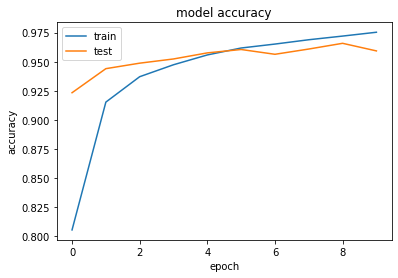

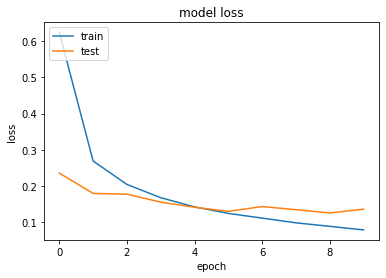

In [28]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()